In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.av_dataset import Dataset

/Users/Yaxuan/Github/stat-215-final/csi-pecarn-rule-vetting


/Users/Yaxuan/opt/anaconda3/envs/“rule-env”/lib/python3.7/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
avdf_all = Dataset().get_data()
avdf_ran = Dataset().get_data(use_robust_av = False, control_types=['ran'])
avdf_moi = Dataset().get_data(use_robust_av = False, control_types=['moi'])
avdf_ems = Dataset().get_data(use_robust_av = False, control_types=['ems'])

avdf_ran_train = avdf_ran[0]
avdf_ran_tuning = avdf_ran[1]
avdf_ran_testing = avdf_ran[2]
print(avdf_ran_train.shape)
print(avdf_ran_tuning.shape)
print(avdf_ran_testing.shape)

(821, 23)
(279, 23)
(290, 23)


### Variable selection by tree-based methods

Models:
- CART
- Random Forest

-----

Both methods can give variance importance by two methods:
- Decreasing of Gini Index
- Permutation importance:
    - on training set
    - on tuning set
    
CMT: The results are not so stable among all method. I kindly go for RF with permutation importance on tuning set for interpretation and good agreement with Leolard(2011).

-----

Considering different weighting:
- unsymmetric loss function
- weighted in final voting(classification threshold)

CMT: the first one is difficult to argue the hyperparameter for the weight. In my exploration, it doesn't change tree results much (I tried 10:1). And the second method has intuitive visulization by ROC curve, but how to choose final decision rules?

-----

TODO:
- age
- different control type
- considering full variable list

In [3]:
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay

In [4]:
# data preparation

X = avdf_ran_train.loc[:,'AlteredMentalStatus':'NonAmbulatory']
y = avdf_ran_train['csi_injury'].astype('int')
X_tuning = avdf_ran_tuning.loc[:,'AlteredMentalStatus':'NonAmbulatory']
y_tuning = avdf_ran_tuning['csi_injury'].astype('int')

Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck','Torticollis',
          'SubInj_TorsoTrunk','Predisposed','HighriskDiving','HighriskMVC']
if_Leo = [1 if (x in Leonard) else 0 for x in X.columns]
d = {'name':X.columns, 'if_Leo' : if_Leo}

VI_df = pd.DataFrame(data = d)

In [5]:
# cart with default setting
cart = tree.DecisionTreeClassifier()
cart = cart.fit(X,y)

VI_df['cart_gini'] = (-cart.feature_importances_).argsort().argsort()

perm1 = permutation_importance(cart, X, y, n_repeats = 20, random_state = 1)
# VI_df['cart_perm_train'] = (-perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(cart, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['cart_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()

In [6]:
# cart with max_depth parameter
cart2 = tree.DecisionTreeClassifier(max_depth = 4)
cart2 = cart2.fit(X,y)

# VI_df['cart2_dini'] = (-cart2.feature_importances_).argsort().argsort()

# perm = permutation_importance(cart2, X, y, n_repeats=20, random_state=42)
# VI_df['cart2_perm_train'] = (-perm.importances_mean).argsort().argsort()
# perm = permutation_importance(cart2, X_tuning, y_tuning, n_repeats=10, random_state=42)
# VI_df['cart2_perm_tuning'] = (-perm.importances_mean).argsort().argsort()

#### CART Tree with max_depth = 4

cannot seperate two class very well...

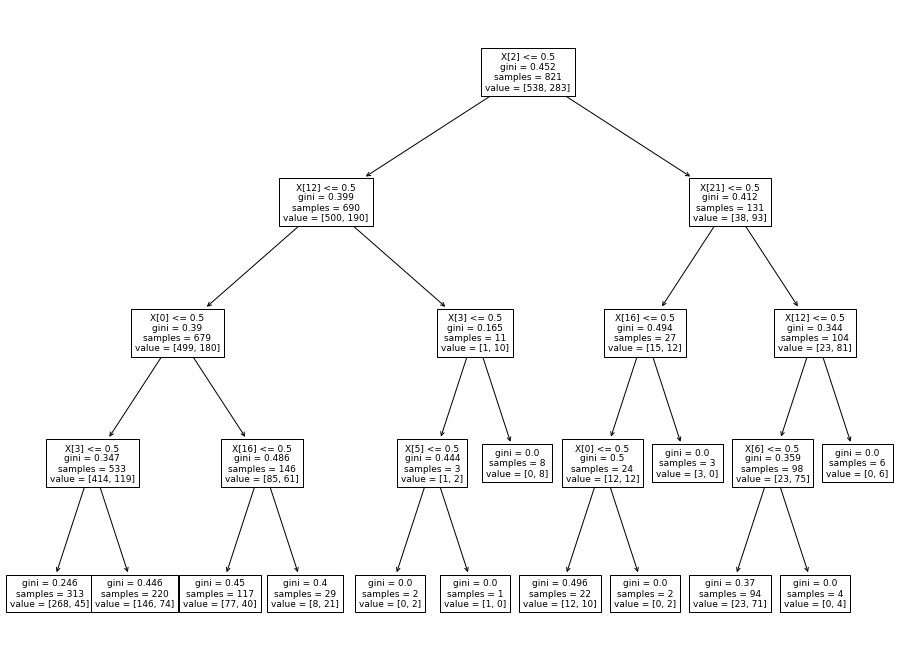

In [7]:
# plot tree
plt.figure(figsize=(16,12))  # set plot size (denoted in inches)
tree.plot_tree(cart2, fontsize=9)
plt.show()

In [8]:
rf = RandomForestClassifier(n_estimators = 200)
rf = rf.fit(X,y)

VI_df['rf_gini'] = (-rf.feature_importances_).argsort().argsort()

perm1 = permutation_importance(rf, X, y, n_repeats = 20, random_state = 1)
# VI_df['rf_perm_train'] = (-perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(rf, X_tuning, y_tuning, n_repeats = 20, random_state = 1)
VI_df['rf_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()


#### Permutation importance of Random Forest on tuning set

FocalNeuroFindings are certainly the most important. But the second group of 6-8 variables has large overlap (partly explain why results are unstable).

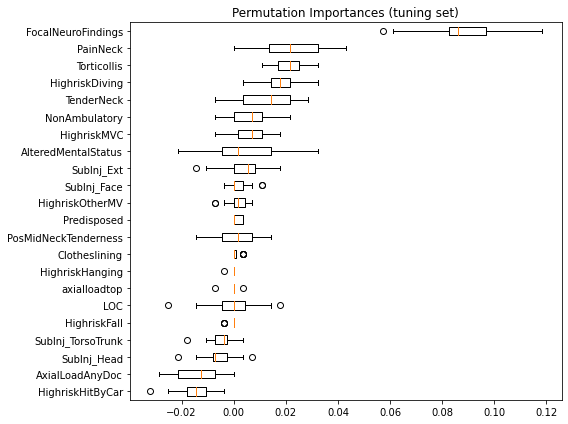

In [9]:
# plots for permutation importantce of RF algorithm on tuning set
result = permutation_importance(rf, X_tuning, y_tuning, n_repeats = 20, random_state = 1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (tuning set)")
fig.tight_layout()
plt.show()

In [10]:
rf_weighted = RandomForestClassifier(class_weight = {1:10, 0:1})
rf_weighted = rf_weighted.fit(X,y)

VI_df['wrf_gini'] = (-rf_weighted.feature_importances_).argsort().argsort()

s_weight = [1]*len(y)
s_weight[list(y) == 1] = 10
st_weight = [1]*len(y_tuning)
st_weight[list(y_tuning) == 1] = 10

perm1 = permutation_importance(rf_weighted, X, y, n_repeats = 20, 
                               random_state = 1,sample_weight = s_weight)
# VI_df['wrf_perm_train'] = (-perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(rf_weighted, X_tuning, y_tuning, n_repeats = 20, 
                               random_state = 1,sample_weight = st_weight)
VI_df['wrf_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()

#### Summary table

- kind of unstable but not too bad? 
- *Predisposed* and *SubInj_TorsoTrunk* which are selected in original paper seems not relatively important in tree-based methods;
- Tree-based methods love *LOC*, *NonAmbulatory* and *TenderNeck* which are not selected in original paper;

In [11]:
VI_df = VI_df.assign(ave_rank = VI_df.mean(axis = 1))
VI_df.sort_values(by = 'ave_rank')

,name,if_Leo,cart_gini,cart_perm_tuning,rf_gini,rf_perm_tuning,wrf_gini,wrf_perm_tuning,ave_rank
2,FocalNeuroFindings,1,0,0,0,0,1,0,0.285714
16,HighriskMVC,1,2,1,4,6,5,3,3.142857
3,PainNeck,1,5,5,5,1,6,1,3.428571
1,LOC,0,1,6,1,16,0,16,5.714286
21,NonAmbulatory,0,3,21,3,5,2,7,5.857143
6,Torticollis,1,9,2,13,2,13,4,6.285714
12,HighriskDiving,1,8,4,9,3,20,5,7.142857
5,TenderNeck,0,14,3,7,4,8,17,7.571429
0,AlteredMentalStatus,1,6,17,2,7,3,18,7.714286
4,PosMidNeckTenderness,0,17,7,10,12,9,2,8.142857


## ROC curves

#### CART and RF

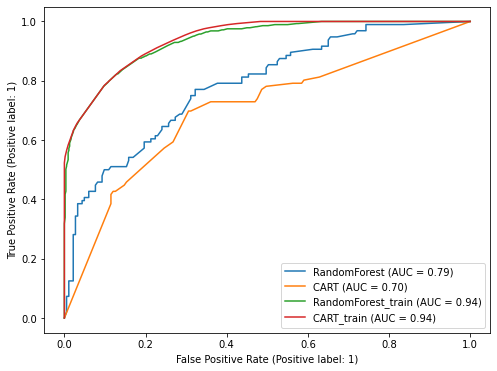

In [12]:
# ax = plt.gca()
fig, ax = plt.subplots(figsize=(8,6))
rf_disp = RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
cart_disp = RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
rf_disp_train = RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest_train")
cart_disp_train = RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART_train")
plt.show()

#### RF: weighted or not

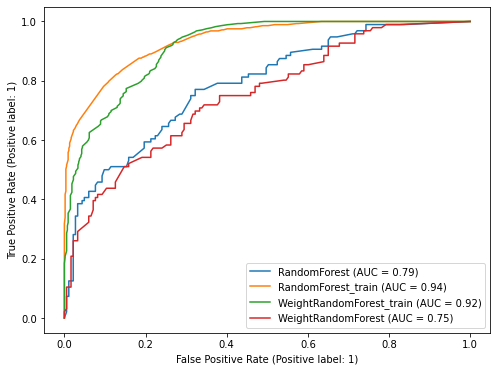

In [13]:
# ax = plt.gca()
fig, ax = plt.subplots(figsize=(8,6))
rf_disp = RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
rf_disp_train = RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest_train")
wrf_disp_train = RocCurveDisplay.from_estimator(rf_weighted, X, y, ax=ax, name = "WeightRandomForest_train")
wrf_disp = RocCurveDisplay.from_estimator(rf_weighted, X_tuning, y_tuning, ax=ax, name = "WeightRandomForest")
plt.show()

#### CART: weighted or not

In [14]:
cart_weighted = tree.DecisionTreeClassifier(class_weight = {1:10, 0:1})
cart_weighted = cart_weighted.fit(X,y)

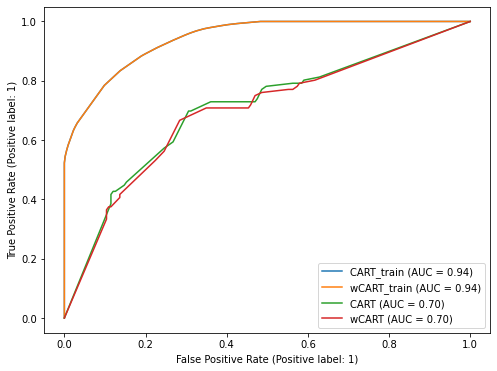

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
cart_disp_train = RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART_train")
wcart_disp_train = RocCurveDisplay.from_estimator(cart_weighted, X, y, ax=ax, name = "wCART_train")
cart_disp = RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
wcart_disp = RocCurveDisplay.from_estimator(cart_weighted, X_tuning, y_tuning, ax=ax, name = "wCART")
plt.show()

#### CART: full tree or max_depth = 4

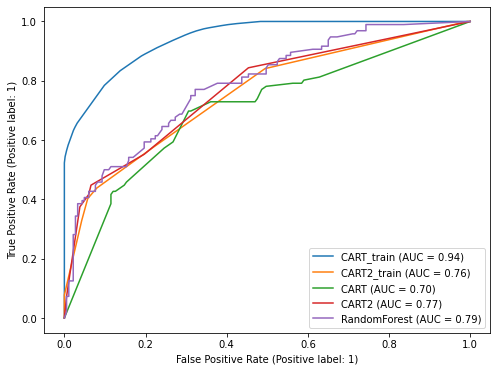

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
cart_disp_train = RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART_train")
cart2_disp_train = RocCurveDisplay.from_estimator(cart2, X, y, ax=ax, name = "CART2_train")
cart_disp = RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
cart2_disp = RocCurveDisplay.from_estimator(cart2, X_tuning, y_tuning, ax=ax, name = "CART2")
rf_disp = RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
plt.show()